## Here we compare the model trained without functional profiles of Orbito-frontal region (yeo network 10) with full model

In [ ]:
import numpy as np
import pandas as pd
import nibabel as nb
import Functional_Fusion.dataset as fdata # from functional fusion module
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.data as cdata
import cortico_cereb_connectivity.cio as cio
import cortico_cereb_connectivity.summarize as cs
import cortico_cereb_connectivity.scripts.script_summarize_weights as cssw
import matplotlib.pyplot as plt
import seaborn as sns
import Functional_Fusion.atlas_map as am
import nitools as nt
import SUITPy as suit
import contextlib
import os

In [2]:
traindata = 'MdWfIbDeNiSoScLa'
parcellation = 'Icosahedron1002'
method = 'NNLS_parallel'

yeo_img = nb.load(gl.conn_dir + f'/maps/yeo17_{parcellation}.plabel.nii')
yeo_data = yeo_img.get_fdata().squeeze()
label_dict = yeo_img.header.get_axis(0).label[0]
atlas,ainf = am.get_atlas('MNISymC3')

### Load full/altered model and evaluate on held-out dataset


In [6]:
df = {}
df_voxel = {}

for name, ext in zip(['full', 'no-yeo10'], ["", "_no-yeo10"]):
    conn_model, train_info = cs.get_model(traindata,parcellation,method+ext,extension='A2_global')  

    model_config = rm.get_model_config()
    model_config['model'] = [conn_model]
    model_config['train_info'] = [train_info]

    eval_config = rm.get_eval_config(eval_dataset='HCPur100', eval_ses='all', cerebellum='MNISymC3', parcellation=parcellation)

    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        df[name], df_voxel[name] = rm.eval_model(None, None, eval_config, model_config);

### Difference plot of evaluation on R_vox

Difference in overall R: -0.002
Average difference in voxel-wise R: -0.002


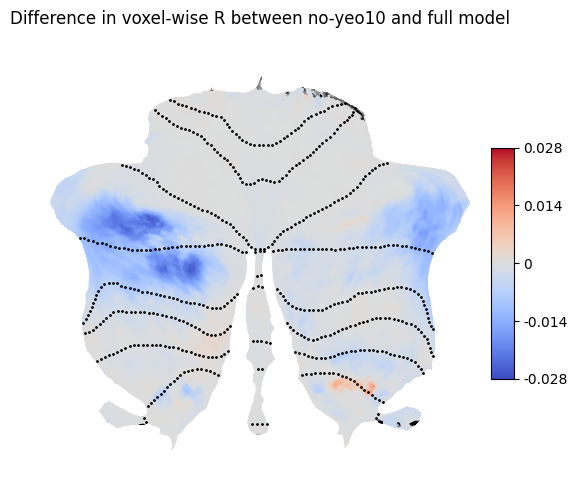

In [29]:
R_vox_diff = np.nanmean(df_voxel['no-yeo10']['R_vox'], axis=0) - np.nanmean(df_voxel['full']['R_vox'], axis=0)
nifti_image = atlas.data_to_nifti(R_vox_diff)
data = suit.vol_to_surf(nifti_image,space='MNISymC')
max_diff = np.nanmax(np.abs(data))
fig, ax = plt.subplots(figsize=(7, 6))
suit.flatmap.plot(data, cmap='coolwarm', cscale=[-max_diff, max_diff], new_figure=False, colorbar=True)
ax.set_title('Difference in voxel-wise R between no-yeo10 and full model', fontsize=12);
print(f'Difference in overall R: {np.nanmean(df["no-yeo10"]["R_eval"], axis=0) - np.nanmean(df["full"]["R_eval"], axis=0):.3f}')
print(f'Average difference in voxel-wise R: {np.nanmean(R_vox_diff):.3f}')